# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров. 

**План занятия**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = r'C:\Users\vschitov\Desktop\Python\DataSets\RealState\train.csv'
TEST_DATASET_PATH = r'C:\Users\vschitov\Desktop\Python\DataSets\RealState\test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [11]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [12]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [13]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Функции для вывода графика**

In [14]:
def sns_join(feature_1, feature_2):
    grid = sns.jointplot(feature_1, feature_2, kind='reg')
    grid.fig.set_figwidth(12)
    grid.fig.set_figheight(12)

    plt.show()

In [15]:
def sns_boxplot(feature, name):
    plt.figure(figsize=(16, 8))

    sns.boxplot(train_df['Price'], feature, whis=1.5)

    plt.xlabel('Price')
    plt.ylabel(name)
    plt.title('Distribution of price')
    plt.show()

**Целевая переменная**

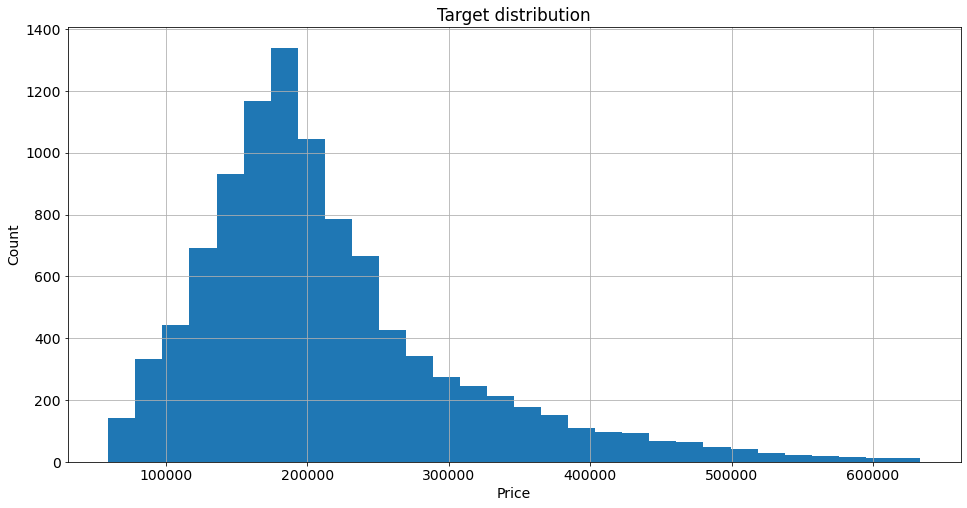

In [16]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [17]:
target_median = train_df["Price"].median()
target_mean = train_df["Price"].mean()

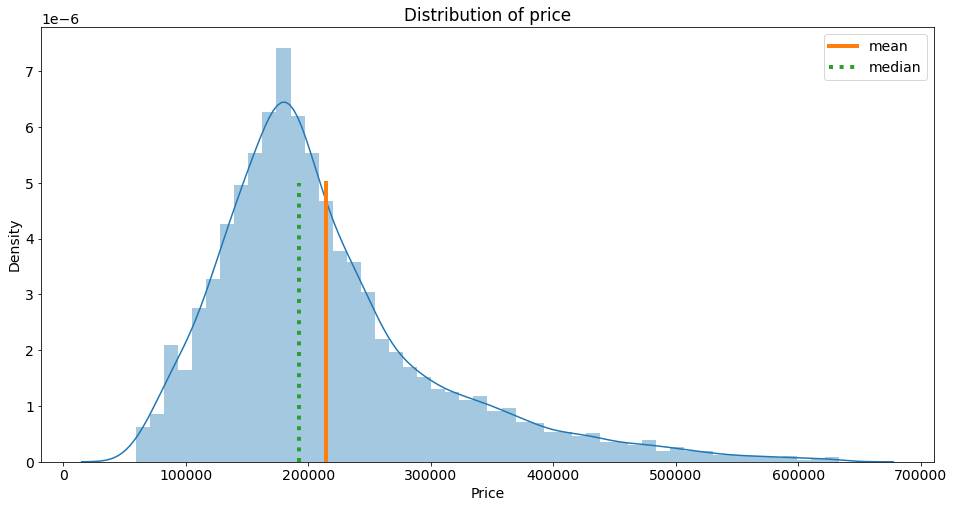

In [18]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label="mean",  linewidth=4, linestyle = "-")
plt.plot([target_median] * 10, y, label='median',  linewidth=4, linestyle = ":")

plt.title('Distribution of price')
plt.legend()
plt.show()

In [19]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])

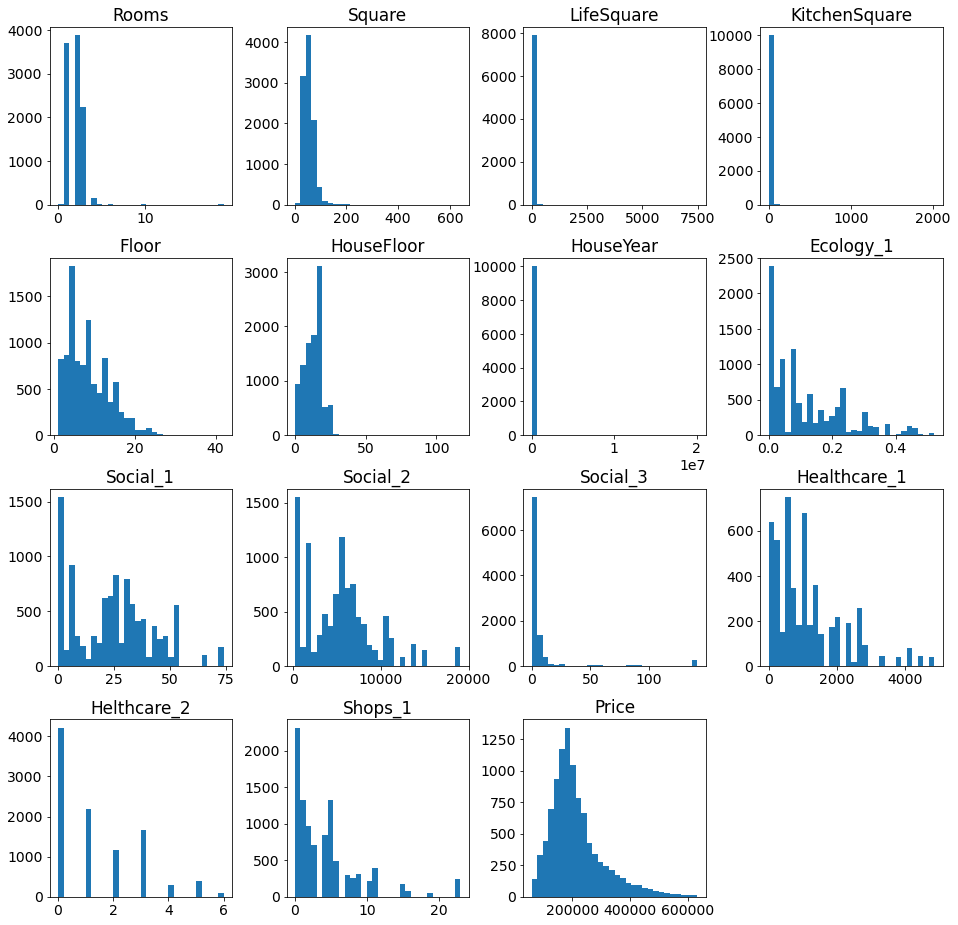

In [20]:
df_num_features.hist(figsize=(16, 16), bins=30, grid=False);

**Категориальные признаки**

In [21]:
df_cat_features = train_df.select_dtypes(include=['object'])
df_cat_features

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,11809,27,B,B,B
1,3013,22,B,B,B
2,8215,1,B,B,B
3,2352,1,B,B,B
4,13866,94,B,B,B
...,...,...,...,...,...
9995,1260,61,B,B,B
9996,16265,27,B,B,A
9997,2795,178,B,B,B
9998,14561,21,B,B,B


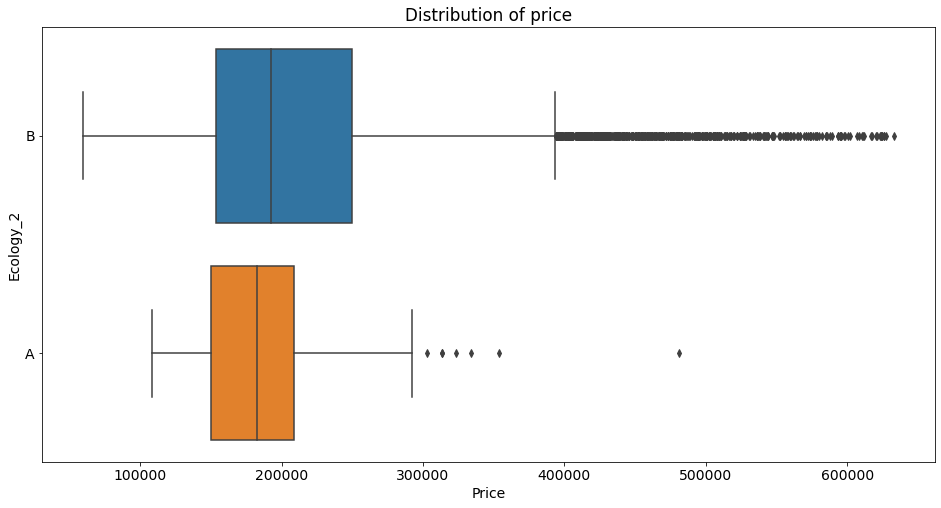

In [22]:
sns_boxplot(train_df['Ecology_2'], 'Ecology_2')

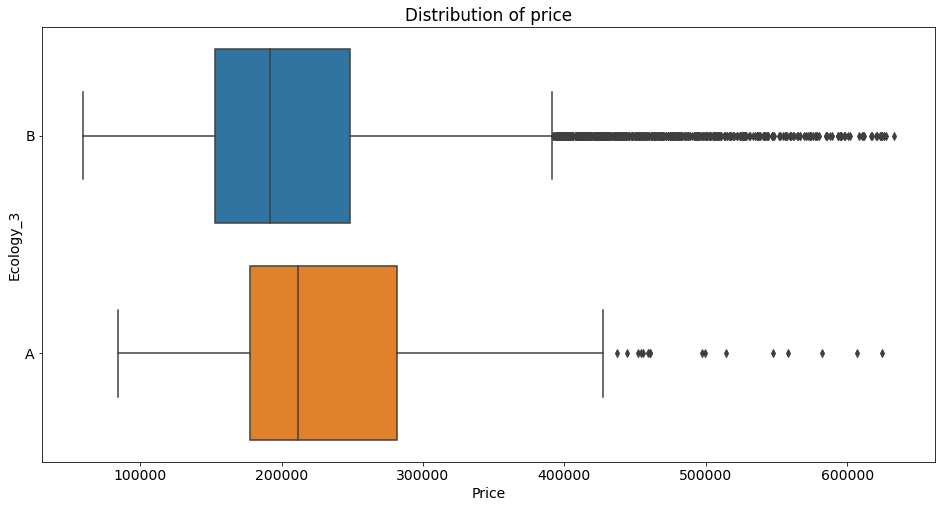

In [23]:
sns_boxplot(train_df['Ecology_3'], 'Ecology_3')

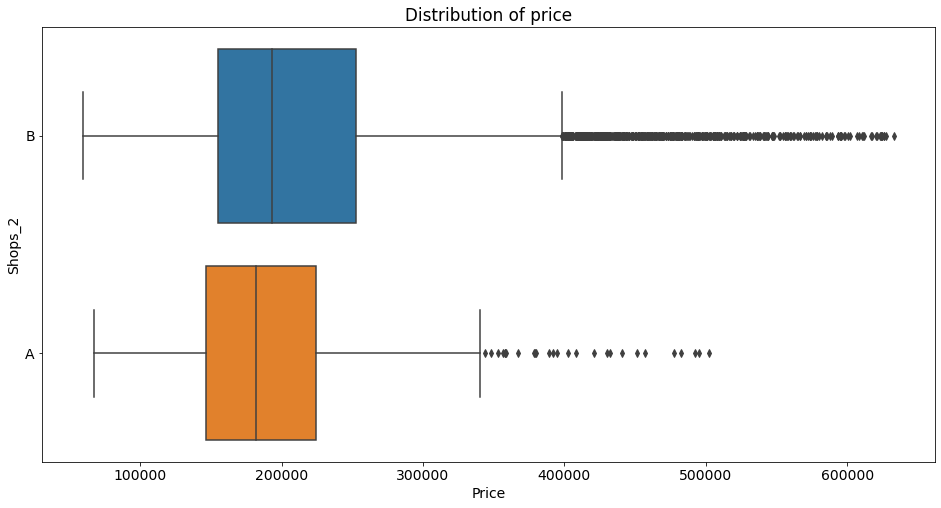

In [24]:
sns_boxplot(train_df['Shops_2'], 'Shops_2')

**Количественные переменные**

Анализ статистик всех признаков анализируемой популяции:

    1. Для признаков LifeSquare и Healthcare_1 заполнены не все значения
    2. Наблюдатся значительная разница между средним и медианой признаков HouseFloor, Social_3, Healthcare_1
    3. Похожи на выбросы некоторые максимальные значения признаков: LifeSquare, KitchenSquare, HouseFloor,  
    

In [25]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [26]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [27]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
207      1
209      1
205      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [28]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [29]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [30]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**Матрица корреляции**

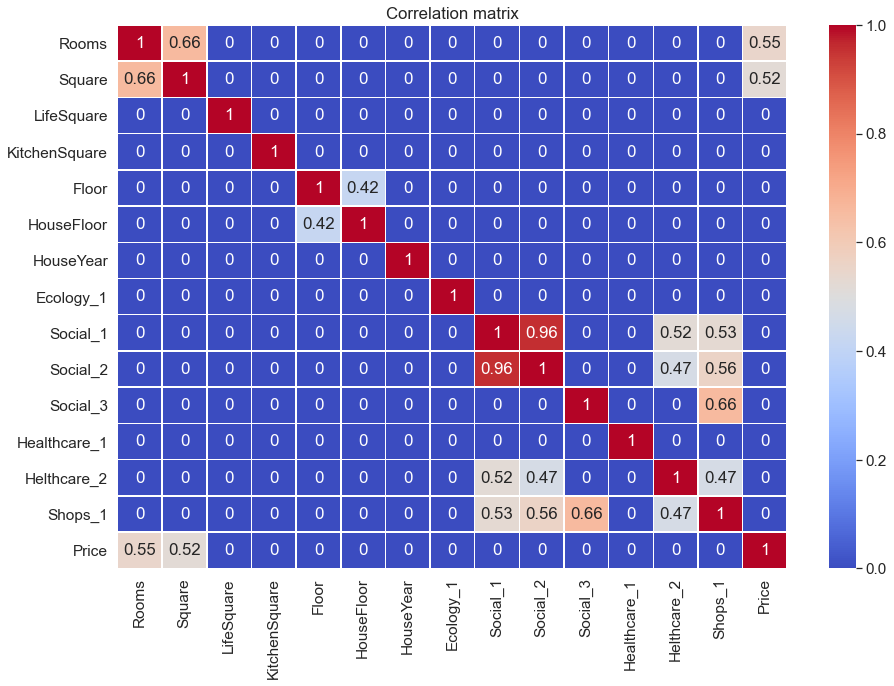

In [31]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

В результате анализа выявил следующие интересные случаи:
1. Между DistrictId и HealthCare_2 есть небольшая взаимосвязь, можно побробовать ее использовать
2. Существуют достаточно сильная связь между общей площадью и комнатами
3. Интересно, что социальные признаки почти идентичны друг другу

In [32]:
train_df['Social_1']

0       11
1       30
2       33
3        1
4       33
        ..
9995    52
9996     2
9997    20
9998    47
9999    43
Name: Social_1, Length: 10000, dtype: int64

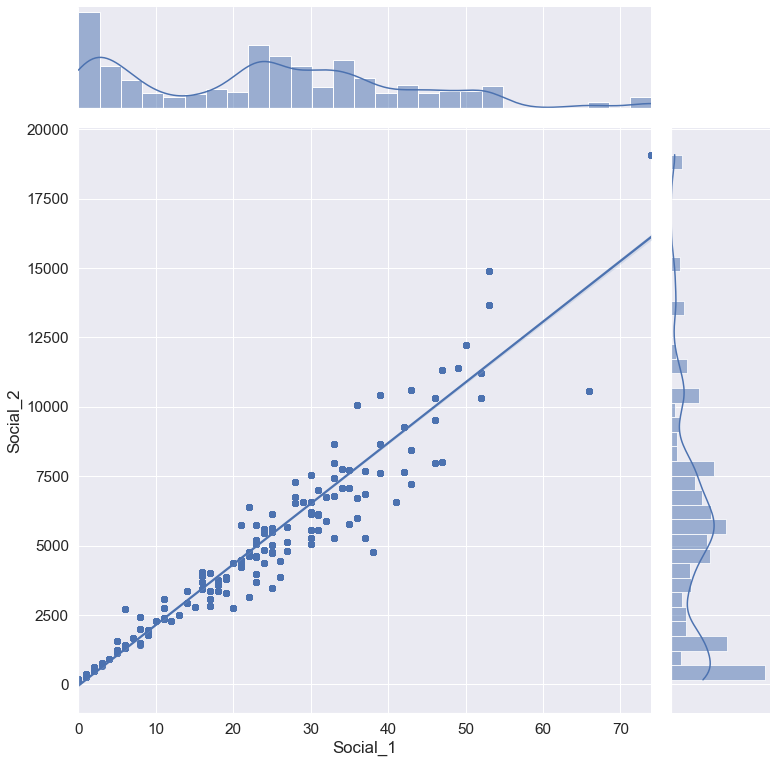

In [33]:
sns_join(train_df['Social_1'], train_df['Social_2'])

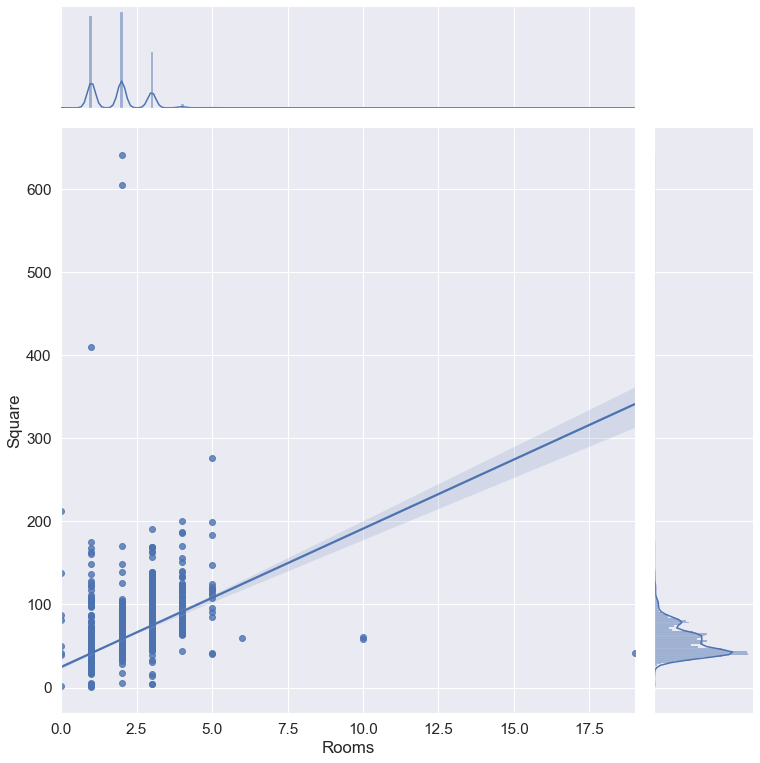

In [34]:
sns_join(train_df['Rooms'], train_df['Square'])

### 2. Обработка выбросов  <a class='anchor' id='outlier'>
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

**Rooms**

In [35]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [36]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [37]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [38]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [39]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

Согласно правилам по проектированию и строительству СП 31-107-2004 площадь кухни должна быть: в однокомнатных квартирах - не менее 5 м (в том числе кухни-ниши); в квартирах с числом жилых комнат две и более - не менее 8 м

In [40]:
train_df['KitchenSquare'].value_counts().sort_index()

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

In [41]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [42]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [43]:
train_df.loc[((train_df['KitchenSquare']) < 8 | (train_df['Rooms'] >=2 )), ["KitchenSquare", "Rooms"]]

,KitchenSquare,Rooms
24,0.0,1.0
38,0.0,2.0
64,0.0,3.0
88,0.0,2.0
94,0.0,1.0
...,...,...
9945,0.0,2.0
9950,0.0,3.0
9965,0.0,3.0
9991,0.0,2.0


In [44]:
condition_for_one_room_kitch = ((train_df['KitchenSquare'] < 5) & (train_df['Rooms'] <= 1))

In [45]:
train_df.loc[condition_for_one_room_kitch, ['KitchenSquare']] = 5
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,5.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [46]:
condition_for_more_one_room_kitch = ((train_df['KitchenSquare'] < 8) & (train_df['Rooms'] >= 2))

In [47]:
train_df.loc[condition_for_more_one_room_kitch, ['KitchenSquare']] = 8
train_df[["Rooms", "KitchenSquare"]].value_counts()

Rooms  KitchenSquare
2.0    8.0              3027
1.0    5.0              1720
3.0    8.0              1463
1.0    8.0               603
3.0    10.0              442
1.0    6.0               364
2.0    9.0               347
1.0    9.0               338
       10.0              325
2.0    10.0              273
1.0    7.0               257
3.0    9.0               140
2.0    11.0              108
3.0    12.0              106
2.0    12.0              104
4.0    8.0                88
3.0    11.0               66
1.0    11.0               49
       12.0               35
4.0    10.0               32
2.0    13.0               25
1.0    13.0               22
3.0    13.0               18
4.0    9.0                15
5.0    8.0                11
4.0    11.0                9
       12.0                4
5.0    9.0                 3
       10.0                3
4.0    13.0                2
5.0    11.0                1
dtype: int64

**Life Square**

Согласно правилам по проектированию и строительству СП 31-107-2004: В однокомнатной квартире площадь общей комнаты должна быть не менее 14 м; в квартирах с числом жилых комнат две и более - не менее 16 м.

In [48]:
train_df['LifeSquare'].value_counts().sort_index()

0.370619       1
0.641822       1
0.795539       1
0.873147       1
1.049867       1
              ..
263.542020     1
410.639749     1
461.463614     1
638.163193     1
7480.592129    1
Name: LifeSquare, Length: 7887, dtype: int64

In [49]:
condition_for_lif_square_one_room = ((train_df['LifeSquare'] < 14) & (train_df['Rooms'] <= 1))
condition_for_lif_square_one_room.value_counts()

False    9879
True      121
dtype: int64

In [50]:
train_df.loc[condition_for_lif_square_one_room, ["LifeSquare"]] = 14

**Square**

Из анализа проведенного выше следует, что общая площадь квартир должна составлять как минимум мин. размер кухни + мин. размер комнаты + нежилые помещения (для однокомнотной кв.) = 5 + 14 + 3 = 22 м кв.
Для квартир с двумя комнатами и более 8 + 16 + 3 = 27 м кв.

In [51]:
(train_df["Square"] < 22).value_counts()

False    9975
True       25
Name: Square, dtype: int64

In [52]:
condition_for_more_one_room_square = (train_df["Square"] < 22) & (train_df["Rooms"] <= 1)
condition_for_more_one_room_square.value_counts()

False    9981
True       19
dtype: int64

In [53]:
train_df.loc[condition_for_more_one_room_square, ["Square"]] = 22

In [54]:
condition_for_more_one_room_square = (train_df["Square"] < 27) & (train_df["Rooms"] > 1)
condition_for_more_one_room_square.value_counts()

False    9994
True        6
dtype: int64

In [55]:
train_df.loc[condition_for_more_one_room_square, ["Square"]] = 27

**HouseFloor, Floor**

Согласно википедии самое высокое здание в Москве - это Башня Федерации. Её высота 95 этажей. Соответственно можно поставить ограничение на максимальное количество этажей.

In [56]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [57]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [58]:
train_df.loc[train_df['HouseFloor'] > 95, ['HouseFloor']] = 95

In [59]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [60]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [61]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [62]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [63]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: x)

In [64]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

In [65]:
train_df[['Floor', 'HouseFloor']]

,Floor,HouseFloor
0,4.0,10.0
1,7.0,8.0
2,2.0,17.0
3,10.0,22.0
4,16.0,16.0
...,...,...
9995,3.0,12.0
9996,13.0,13.0
9997,3.0,5.0
9998,3.0,9.0


**HouseYear**

In [66]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [67]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков  <a class='anchor' id='nan'>

In [68]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [69]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,8.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,8.0


**LifeSquare**

Для тех случаев, где жилая площадь не заполнена, вычтем существующею общую площадь квартиры из кухни и нежилого помещения. Для тех случаев, где сумма получится меньше 14, приведем значение жилой площади и общей к указанной ранее в условии (14 метров минимум для жилой площади и минимум) 

In [70]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

Данный признак связан с охраной здоровья (близость больниц), попробуем сгруппировать районы и вычислить медиану для них по данному признаку и заполнить ею. Если для каких-то районов не будет признака то можно заполнить общей медианой

In [71]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,3097,0,NaN,0,0,B,305018.871089,0,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,6207,1,1183.0,1,0,B,177734.553407,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,5261,0,240.0,3,1,B,282078.720850,0,0,0
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,264,0,NaN,0,1,B,168106.007630,0,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,8667,2,NaN,0,6,B,343995.102962,0,0,0


In [72]:
train_df.loc[train_df["Healthcare_1"].notna(), ["Healthcare_1"]]

,Healthcare_1
1,1183.0
2,240.0
5,2078.0
6,80.0
7,176.0
...,...
9990,125.0
9991,540.0
9992,320.0
9994,30.0


In [73]:
train_df["Healthcare_nan"] = 0

In [74]:
train_df.loc[train_df["Healthcare_1"].isna(), ["Healthcare_nan"]] = 1

In [75]:
train_df["Healthcare_1"].isna()

0        True
1       False
2       False
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Name: Healthcare_1, Length: 10000, dtype: bool

In [76]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,NaN,0,0,B,305018.871089,0,0,1,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,0,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,0,0,0,0
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,0,NaN,0,1,B,168106.007630,0,0,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,2,NaN,0,6,B,343995.102962,0,0,0,1


In [77]:
MeanByHealth = train_df[train_df["Healthcare_nan"] == 0].groupby(by = "DistrictId", as_index=False).agg({'Healthcare_1':'mean'}).\
                                            rename(columns={'Healthcare_1':'MeanByHealth'})

In [78]:
MeanByHealth_general = train_df.loc[train_df["Healthcare_nan"] == 0,["Healthcare_1"]].mean()

In [79]:
train_df = train_df.merge(MeanByHealth, how = "left", on = "DistrictId")

In [80]:
train_df.loc[train_df["MeanByHealth"].isna(), ["MeanByHealth"]] = MeanByHealth_general['Healthcare_1']

In [81]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan,MeanByHealth
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887600,56.345465,40.096674,7.887800,7.918200,12.956100,1984.872400,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.001200,0.182500,0.211300,0.479800,1066.383767
std,0.811438,21.000461,77.401630,1.731159,5.186386,6.401115,18.416347,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.034622,0.386275,0.408251,0.499617,823.093035
min,1.000000,22.000000,0.641822,5.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774881,25.041556,8.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.000000,0.000000,0.000000,0.000000,389.164179
50%,2.000000,52.513310,34.805337,8.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.000000,0.000000,0.000000,0.000000,1142.904460
75%,2.000000,65.900625,47.944599,8.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.000000,0.000000,0.000000,1.000000,1322.000000
max,5.000000,641.065193,7480.592129,13.000000,42.000000,95.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,4849.000000


In [82]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[((X['KitchenSquare']) < 8 | (X['Rooms'] >=2 )), ["KitchenSquare", "Rooms"]]

        condition = ((X['KitchenSquare'] < 5) & (X['Rooms'] <= 1))
        X.loc[condition, ['KitchenSquare']] = 5
        
        condition = ((X['KitchenSquare'] < 8) & (X['Rooms'] >= 2))
        X.loc[condition, ['KitchenSquare']] = 8
        
        # HouseFloor, Floor
        X.loc[X['HouseFloor'] > 95, ['HouseFloor']] = 95
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: x)
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
#         if 'Healthcare_1' in X.columns:
#             X.drop('Healthcare_1', axis=1, inplace=True)
        X["Healthcare_1"].fillna(self.medians["Healthcare_1"])
            
        # LifeSquare
        
        condition = ((X['LifeSquare'] < 14) & (X['Rooms'] <= 1))
        X.loc[condition, ["LifeSquare"]] = 14
        
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # Square
        
        condition = (X["Square"] < 22) & (X["Rooms"] <= 1)
        X.loc[condition, ["Square"]] = 22

        condition = (X["Square"] < 27) & (X["Rooms"] > 1)
        X.loc[condition, ["Square"]] = 27
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [83]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [84]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [85]:
train_df["LifeSquare"].isna().value_counts()

False    10000
Name: LifeSquare, dtype: int64

In [86]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan,MeanByHealth,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,0,1,305018.871089,0,0,1,1,1142.904460,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,0,1223.830986,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,0,228.771930,652
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,0,1,1,168106.007630,0,0,1,1,228.771930,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,1,1142.904460,89


In [87]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [88]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [89]:
train_df['IsDistrictLarge']

0       1
1       0
2       1
3       1
4       0
       ..
9995    1
9996    1
9997    0
9998    1
9999    0
Name: IsDistrictLarge, Length: 10000, dtype: int32

**MedPriceByDistrict**

In [90]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [91]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan,MeanByHealth,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,1,305018.871089,0,0,1,1,1142.904460,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,177734.553407,0,0,0,0,1223.830986,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,282078.720850,0,0,0,0,228.771930,652,1,244005.272380
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,1,168106.007630,0,0,1,1,228.771930,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1,343995.102962,0,0,0,1,1142.904460,89,0,201584.441255


**MedPriceByFloorYear**

In [92]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [93]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [94]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3.0, 5.0]
1         (5.0, 9.0]
2         (0.0, 3.0]
3        (9.0, 15.0]
4       (15.0, 42.0]
            ...     
9995      (0.0, 3.0]
9996     (9.0, 15.0]
9997      (0.0, 3.0]
9998      (0.0, 3.0]
9999      (5.0, 9.0]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[float64]): [(0.0, 3.0] < (3.0, 5.0] < (5.0, 9.0] < (9.0, 15.0] < (15.0, 42.0]]

In [95]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan,MeanByHealth,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,0,1,1,1142.904460,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,1223.830986,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,228.771930,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,0,0,1,1,228.771930,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,0,1,1142.904460,89,0,201584.441255,3,5


In [96]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.112959
1,1,2,324303.812481
2,1,3,422668.384063
3,1,4,274992.472366
4,2,1,467230.539057


In [97]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan,MeanByHealth,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,1,1,1142.904460,851,1,213530.788443,6,2,161744.506404
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,1223.830986,78,0,146032.829834,3,3,192213.977261
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,228.771930,652,1,244005.272380,4,1,205210.068542
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,0,1,1,228.771930,652,1,146735.671740,3,4,184374.328532
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,1,1142.904460,89,0,201584.441255,3,5,175503.767602


In [98]:
train_df[['DistrictId', 'Helthcare_2']].value_counts()

DistrictId  Helthcare_2
27          0              801
1           0              595
23          0              565
6           0              511
30          3              228
                          ... 
199         2                1
117         2                1
205         2                1
207         2                1
119         0                1
Length: 351, dtype: int64

In [99]:
train_df['Helthcare_2'].unique()

array([0, 1, 3, 2, 5, 4, 6], dtype=int64)

In [100]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan,MeanByHealth,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,...,0,1,1,1142.904460,851,1,213530.788443,6,2,161744.506404
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,1223.830986,78,0,146032.829834,3,3,192213.977261
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,228.771930,652,1,244005.272380,4,1,205210.068542
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,...,0,1,1,228.771930,652,1,146735.671740,3,4,184374.328532
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,1,1142.904460,89,0,201584.441255,3,5,175503.767602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,8.0,3.0,12.0,1981,0.300323,...,0,0,1,80.000000,118,1,232514.855623,4,1,205210.068542
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,...,1,0,1,1142.904460,851,1,165683.084779,3,4,184374.328532
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,...,0,0,1,628.000000,7,0,165953.912580,3,1,178890.558191
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,0,0,0,247.557692,165,1,153921.400690,3,1,178890.558191


In [101]:
train_df["Helthcare_2"].unique()

array([0, 1, 3, 2, 5, 4, 6], dtype=int64)

In [102]:
MidPriceHealth = train_df[["Helthcare_2", "Price"]].groupby(by = "Helthcare_2", as_index = False).agg({"Price" : "mean"})\
.rename(columns = {"Price": "MeanPriceByHealth"})
MidPriceHealth

,Helthcare_2,MeanPriceByHealth
0,0,182519.350508
1,1,237650.914372
2,2,225682.631144
3,3,231941.391475
4,4,262338.534955
5,5,269222.813197
6,6,250156.814689


In [103]:
pd.set_option('display.max_columns', 100)
train_df.merge(MidPriceHealth, how = "left", on = "Helthcare_2")


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_nan,MeanByHealth,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,MeanPriceByHealth
0,11809,27,3.0,115.027311,102.027311,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.871089,0,0,1,1,1142.904460,851,1,213530.788443,6,2,161744.506404,182519.350508
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407,0,0,0,0,1223.830986,78,0,146032.829834,3,3,192213.977261,237650.914372
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850,0,0,0,0,228.771930,652,1,244005.272380,4,1,205210.068542,231941.391475
3,2352,1,1.0,40.409907,32.409907,5.0,10.0,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.007630,0,0,1,1,228.771930,652,1,146735.671740,3,4,184374.328532,182519.350508
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.102962,0,0,0,1,1142.904460,89,0,201584.441255,3,5,175503.767602,182519.350508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,8.0,3.0,12.0,1981,0.300323,1,1,52,10311,6,NaN,1,9,1,119367.455796,0,0,0,1,80.000000,118,1,232514.855623,4,1,205210.068542,237650.914372
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0,199715.148807,0,1,0,1,1142.904460,851,1,165683.084779,3,4,184374.328532,182519.350508
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,1,1,20,4386,14,NaN,1,5,1,165953.912580,0,0,0,1,628.000000,7,0,165953.912580,3,1,178890.558191,237650.914372
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,1,1,47,8004,3,125.0,3,5,1,171842.411855,0,0,0,0,247.557692,165,1,153921.400690,3,1,178890.558191,231941.391475


In [104]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.mean_price_by_healthy_ = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
#         if y is not None:  
#             self.mean_price_by_healthy_ = df[["Helthcare_2", "Price"]].groupby(by = "Helthcare_2", as_index = False).agg({"Price" : "mean"})\
#             .rename(columns = {"Price": "MeanPriceByHealth"})
#             self.med_price_by_floor_year_mean = self.mean_price_by_healthy_.mean()
        
#         if y is not None:
#             self.mean_price_by_healthy = df[["Helthcare_2", "Price"]].groupby(by = "Helthcare_2", as_index = False).agg({'Price':'mean'})\
#             .rename(columns = {"Price" : "MidPriceHealth"}
#             self.mean_price_by_healthy_ = self.mean_price_by_healthy["MidPriceHealth"].mean()
            
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
    
        if self.mean_price_by_healthy_ is not None:
            X = X.merge(self.mean_price_by_healthy_, how = "left", on = "Helthcare_2")
            X.fillna(self.med_price_by_floor_year_mean, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [105]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Healthcare_nan',
 'MeanByHealth',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [106]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [107]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [108]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [109]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [110]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [111]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,11585,23,1.0,43.380798,35.380798,5.0,18.0,25.0,1977,0.075779,1,1,6,1437,3,920.0,0,2,1,0,0,0,1,372,0,1,4,2,104300.893609,175622.388268
1,2917,30,3.0,83.596365,72.596365,8.0,3.0,16.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1,0,0,0,1,148,0,1,0,2,197241.123890,179525.641685
2,9635,47,2.0,53.610583,31.289235,8.0,12.0,12.0,1979,0.298205,1,1,16,4048,3,920.0,1,3,1,0,1,0,0,64,0,0,3,2,228796.542555,182358.464115
3,8748,3,2.0,51.877576,30.075022,8.0,3.0,9.0,1974,0.265089,1,1,37,5288,0,1937.0,3,2,1,0,0,0,0,44,0,0,0,2,184712.770172,179525.641685
4,5704,62,1.0,53.810968,45.810968,5.0,4.0,13.0,1977,0.072158,1,1,2,629,1,920.0,0,0,0,0,1,0,1,164,0,1,1,2,131107.271962,186265.707329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6695,10466,84,3.0,76.698682,55.477526,8.0,5.0,5.0,1960,0.006076,1,1,30,5285,0,645.0,6,6,1,0,1,0,0,48,0,0,1,2,258243.457161,186265.707329
6696,12307,60,1.0,40.064914,38.733288,8.0,13.0,14.0,1974,0.007659,1,1,35,7077,56,2301.0,3,19,1,0,0,0,0,6,0,0,3,2,160810.546681,182358.464115
6697,47,2,2.0,45.053898,47.329346,8.0,2.0,5.0,1967,0.000000,1,1,33,7425,1,920.0,2,5,1,0,0,0,0,58,0,0,0,2,212894.088951,179525.641685
6698,161,71,1.0,40.337987,24.811220,8.0,5.0,12.0,1984,0.407276,0,1,9,1768,0,370.0,0,0,0,0,0,0,0,7,0,0,1,3,171588.406357,217602.699683


In [112]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [113]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [114]:
# rf_model = RandomForestRegressor(random_state=21, criterion='mse')
# rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

**Оценка модели**

Train R2:	0.961
Test R2:	0.744


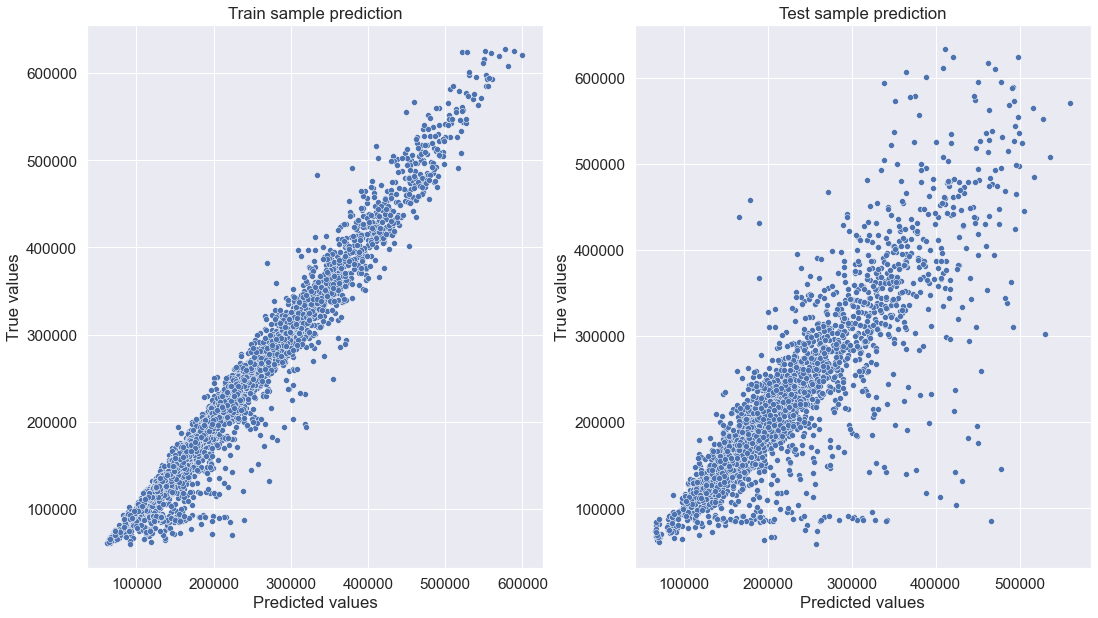

In [115]:
# y_train_preds = rf_model.predict(X_train)
# y_test_preds = rf_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [116]:
# cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
# cv_score

array([0.73450509, 0.71290711, 0.6990503 , 0.71863093, 0.71205791])

In [117]:
# cv_score.mean()

0.7154302675183282

**Важность признаков**

In [118]:
# feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
#                                    columns=['feature_name', 'importance'])

# feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.417632
21,DistrictSize,0.219463
12,Social_3,0.051781
2,LifeSquare,0.037449
7,Ecology_1,0.031752
6,HouseYear,0.031577
11,Social_2,0.031317
0,Rooms,0.027617
24,MedPriceByFloorYear,0.025690
10,Social_1,0.023722


Идея более сложных моделей:

In [119]:
# from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression()
# gb = GradientBoostingRegressor()
# stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)
# stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('rf', RandomForestRegressor(random_state=21))],
                  final_estimator=GradientBoostingRegressor())

Train R2:	0.918
Test R2:	0.737


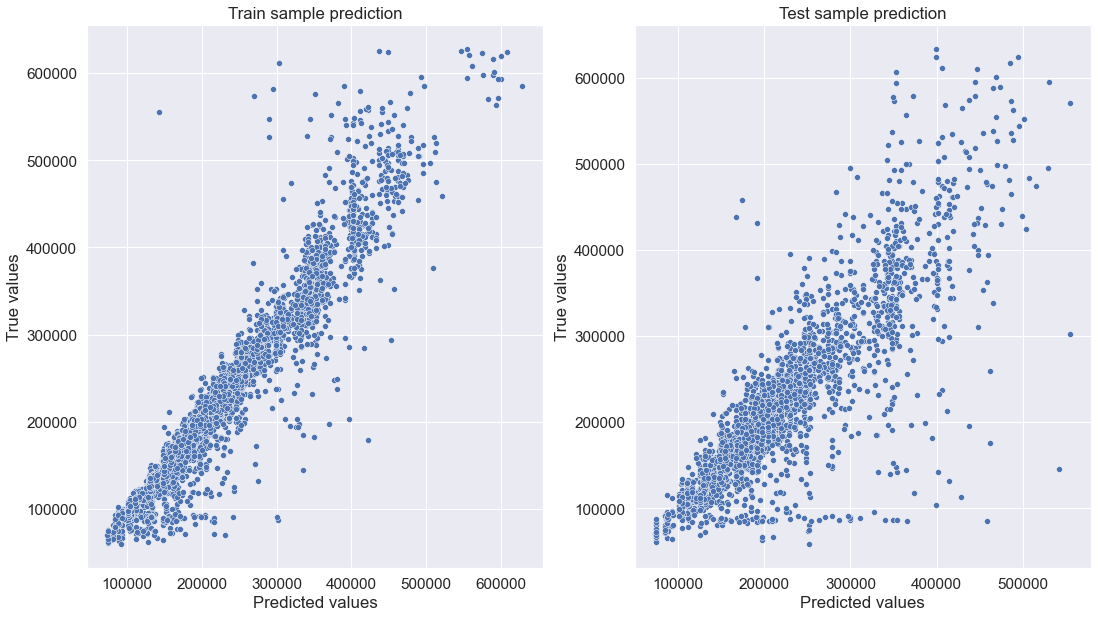

In [120]:
# y_train_preds = stack.predict(X_train)
# y_test_preds = stack.predict(X_valid)

# evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [121]:
# from sklearn.tree import DecisionTreeRegressor

# dt_model = DecisionTreeRegressor(criterion='mse', 
#                                  max_depth=1000, # глубина дерева  
#                                  min_samples_leaf=100, # минимальное кол-во наблюдений в листе дерева
#                                  random_state=42)
# dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1000, min_samples_leaf=100, random_state=42)

Train R2:	0.656
Test R2:	0.658


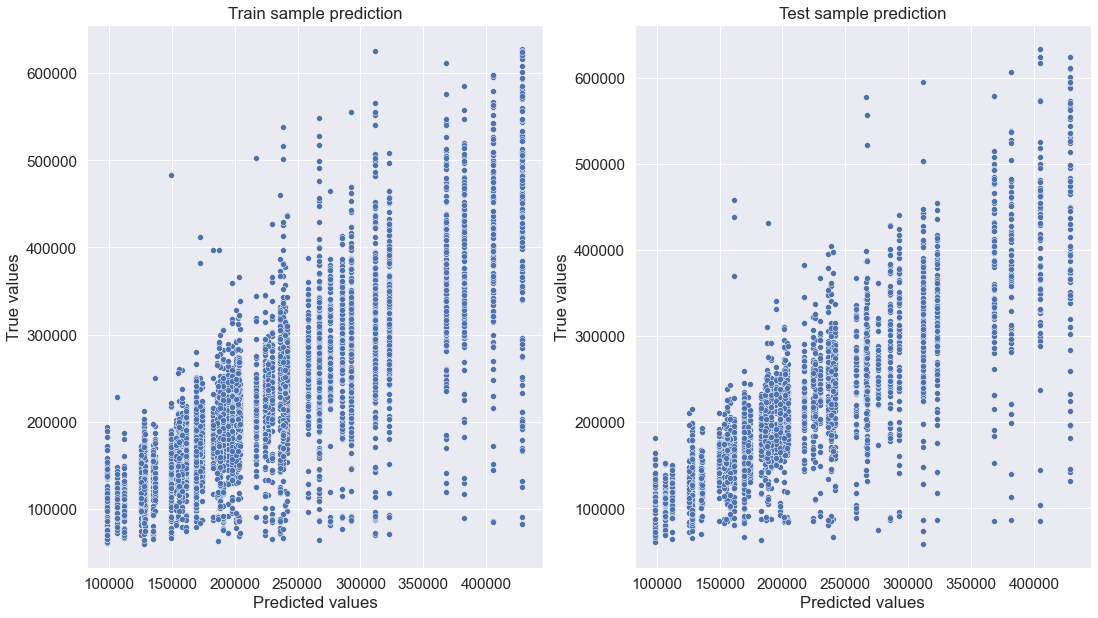

In [122]:
# y_train_preds_ = dt_model.predict(X_train)
# y_test_preds_ = dt_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds_, y_valid, y_test_preds_)

In [123]:
# from sklearn.ensemble import BaggingRegressor
# BaggingRegressor(RandomForestRegressor(), n_estimators=10)

BaggingRegressor(base_estimator=RandomForestRegressor())

In [124]:
# rf_model = RandomForestRegressor(criterion='mse',
#                                  max_depth=70, # глубина дерева  
#                                  min_samples_leaf=15, # минимальное кол-во наблюдений в листе дерева
#                                  random_state=42, 
#                                  n_estimators=100  # кол-во деревьев
#                                  )

# rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=70, min_samples_leaf=15, random_state=42)

Train R2:	0.781
Test R2:	0.726


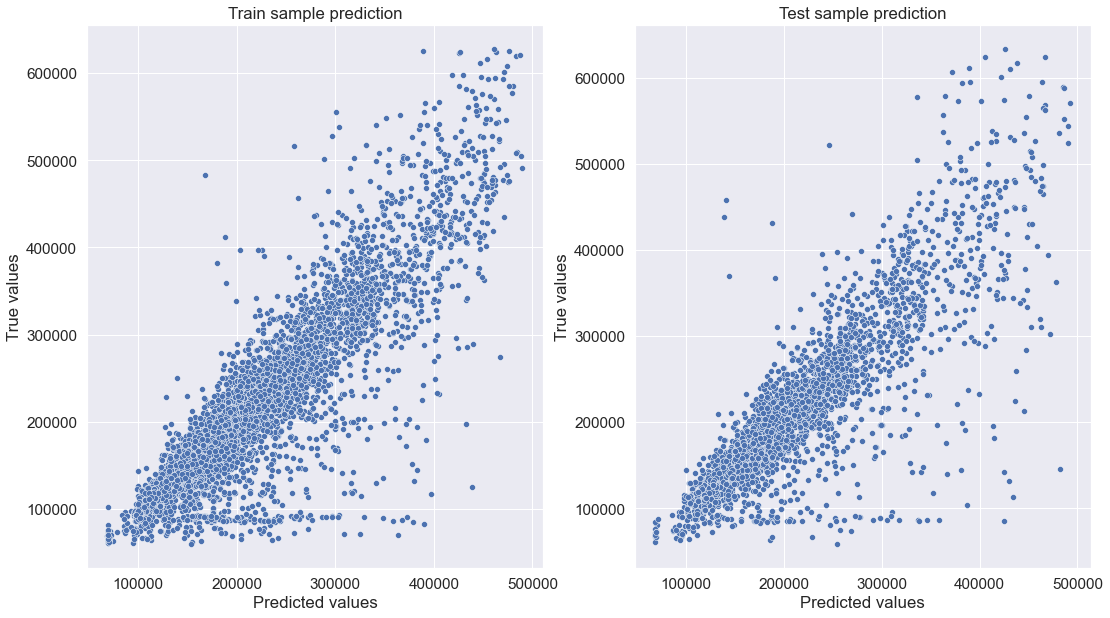

In [125]:
# y_train_preds__ = rf_model.predict(X_train)
# y_test_preds__ = rf_model.predict(X_valid)

# evaluate_preds(y_train, y_train_preds__, y_valid, y_test_preds__)

#### Поиск наилучших параметров для модели:

In [126]:
# gb_model = GradientBoostingRegressor(criterion='mse',
#                                      max_depth=7,
#                                      min_samples_leaf=10,
#                                      random_state=42,  
#                                      n_estimators=100)

In [148]:
# %%time
# params = {'max_depth': [3, 5, 7, 10],
#         'n_estimators': [50, 100, 200, 400]}

# gs = GridSearchCV(gb_model, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(X_train, y_train)

In [ ]:
# GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
#              estimator=GradientBoostingRegressor(criterion='mse', max_depth=7,
#                                                  min_samples_leaf=10,
#                                                  random_state=42),
#              n_jobs=-1,
#              param_grid={'max_depth': [3, 5, 7, 10],
#                          'n_estimators': [50, 100, 200, 400]},
#              scoring='r2')

In [144]:
from sklearn.ensemble import GradientBoostingRegressor
res = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=42, n_estimators = 200, max_depth = 5 )

In [147]:
res.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=10,
                          n_estimators=200, random_state=42)

Train R2:	0.781
Test R2:	0.726


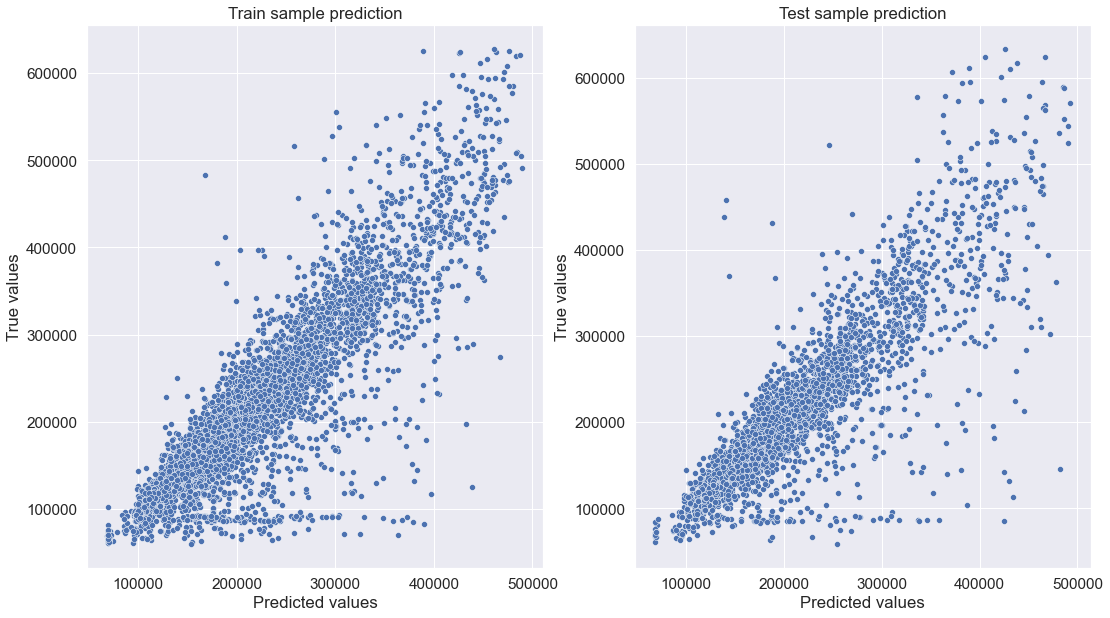

In [149]:
y_train_preds = res.predict(X_train)
y_test_preds = res.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [150]:
test_df.shape

(5000, 25)

In [151]:
test_df.dtypes

Rooms                  float64
Square                 float64
LifeSquare             float64
KitchenSquare          float64
Floor                  float64
HouseFloor             float64
HouseYear                int64
Ecology_1              float64
Ecology_2                int64
Ecology_3                int64
Social_1                 int64
Social_2                 int64
Social_3                 int64
Healthcare_1           float64
Helthcare_2              int64
Shops_1                  int64
Shops_2                  int64
Rooms_outlier            int64
HouseFloor_outlier       int64
HouseYear_outlier        int64
LifeSquare_nan           int32
DistrictSize           float64
new_district             int64
IsDistrictLarge          int32
MedPriceByFloorYear    float64
dtype: object

In [134]:
test_df['MedPriceByFloorYear'] = pd.to_numeric(test_df['MedPriceByFloorYear'], errors='coerce')

In [152]:
submit = pd.read_csv(r'C:\Users\vschitov\Desktop\Python\DataSets\RealState\sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [153]:
predictions = res.predict(test_df)
predictions

array([162538.18048279, 127920.03528736, 138696.57948057, ...,
       144223.97309595, 192286.98435338, 253013.15700938])

In [154]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162538.180483
1,5925,127920.035287
2,960,138696.579481
3,3848,119540.499534
4,746,213223.490632


In [155]:
submit.to_csv('rf_submit_4.csv', index=False)